In [26]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [27]:
from learntools.time_series.style import *  # plot style settings
from learntools.time_series.utils import plot_periodogram, seasonal_plot, plot_lags, make_lags, make_leads

import seaborn as sns
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

from sklearn.preprocessing import StandardScaler

from pathlib import Path
comp_dir = Path('../input/store-sales-time-series-forecasting')

In [28]:
store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales'], #, 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
       # 'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

In [29]:
print('store_sales: \n', store_sales.shape)
store_sales.head()

store_sales: 
 (3000888, 1)


sales
store_nbr family     date             
1         AUTOMOTIVE 2013-01-01    0.0
                     2013-01-02    2.0
                     2013-01-03    3.0
                     2013-01-04    3.0
                     2013-01-05    5.0

In [30]:
mean_by_family_all_years = store_sales.groupby(['family', 'date']).mean()
mean_by_family_all_years = mean_by_family_all_years.unstack('family')['sales']
mean_by_family_all_years.head()

family,AUTOMOTIVE,BABY CARE,BEAUTY,BEVERAGES,BOOKS,BREAD/BAKERY,CELEBRATION,CLEANING,DAIRY,DELI,...,MAGAZINES,MEATS,PERSONAL CARE,PET SUPPLIES,PLAYERS AND ELECTRONICS,POULTRY,PREPARED FOODS,PRODUCE,SCHOOL AND OFFICE SUPPLIES,SEAFOOD
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.000000,0.0,0.037037,15.000000,0.0,3.344241,0.0,3.444444,2.648148,1.316481,...,0.0,2.051870,0.462963,0.0,0.0,0.789574,0.700870,0.0,0.0,0.000000
2013-01-02,4.722222,0.0,3.833333,1335.036987,0.0,486.042938,0.0,1382.018555,432.981476,291.750000,...,0.0,386.508606,318.592590,0.0,0.0,258.812683,98.853928,0.0,0.0,28.273148
2013-01-03,2.981482,0.0,2.314815,964.907410,0.0,341.786682,0.0,1035.055542,333.351837,206.897308,...,0.0,307.359222,232.740738,0.0,0.0,197.673965,66.507187,0.0,0.0,20.265018
2013-01-04,3.129630,0.0,2.462963,1003.092590,0.0,309.666077,0.0,964.148132,336.074066,187.837204,...,0.0,400.480804,209.314819,0.0,0.0,199.491013,82.832703,0.0,0.0,23.946686
2013-01-05,6.333333,0.0,3.537037,1441.074097,0.0,414.217804,0.0,1298.666626,427.444458,254.350830,...,0.0,386.649841,311.462952,0.0,0.0,249.537201,107.964317,0.0,0.0,23.067352


SEAFOOD


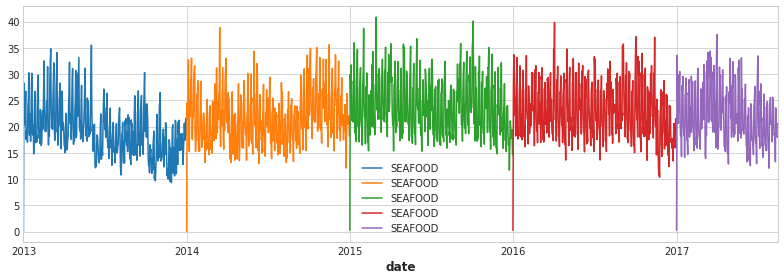

In [31]:
FAMILY = mean_by_family_all_years.columns.values[32]
print(FAMILY)
for year in ['2013','2014','2015','2016', '2017']:
    ax = mean_by_family_all_years.loc[year][FAMILY].plot()
plt.legend()

Since the sales for year show similar behaviour, we use the 2016 data to discover important days in which the sales were higher.

### **Baseline approach: using features derived from time**

In [ ]:
df_target_mean_2017 =  mean_by_family_all_years.loc['2017']

fourier = CalendarFourier(freq="M", order=4) #features for linear regression
dp = DeterministicProcess(
    index=df_target_mean_2017.index,
    constant=True,
    order=1,
    # YOUR CODE HERE
    seasonal=True, #Whether to include seasonal dummies (6 indicator features)
    additional_terms=[fourier],
    drop=True,
)
X_base =  dp.in_sample()
# X_base['new_year'] = (X_base.index.dayofyear == 1)*1.0
# X_base['weekend_1'] = (X_base.index.dayofweek == 5)*1 #high sales
# X_base['weekend_2'] = (X_base.index.dayofweek == 6)*1 #high sales
# X_base['midweek'] = (X_base.index.dayofweek == 3)*1 #low sales
X_base.shape
# midweek == s(5,7)
# 'weekend_1' == s(7,7)

### **Features based on high sales days**

In [32]:
def softmax(df):
    exp_values = np.exp(df.values - np.max(df.values, axis=0))
    return pd.DataFrame(exp_values/np.sum(exp_values, axis=0), index=df.index)


In [33]:
df_target_mean_2016 =  mean_by_family_all_years.loc['2016']

df_softmax = softmax(df_target_mean_2016) #softmax by rows

scaler = StandardScaler()
df_target_mean_2016_scaled = pd.DataFrame(scaler.fit_transform(df_target_mean_2016.values), index=df_target_mean_2016.index)
df_softmax_norm = softmax(df_target_mean_2016_scaled) #softmax by rows after data normalization
print(df_softmax.shape, df_softmax_norm.shape)

(365, 33) (365, 33)


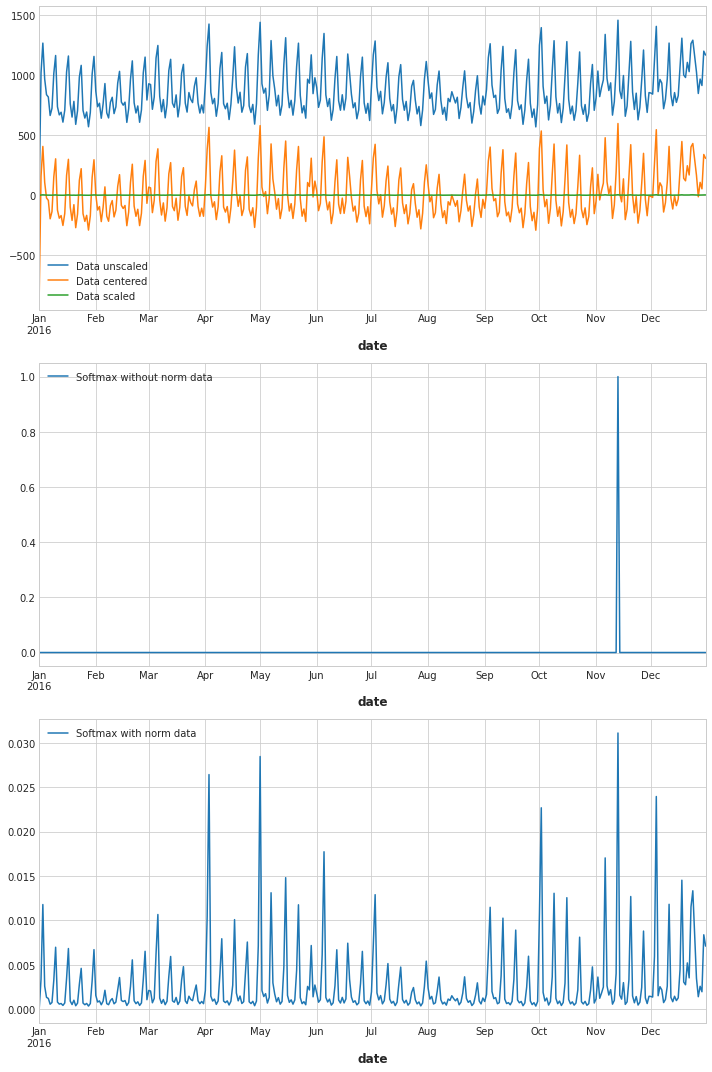

In [34]:
fig, ax = plt.subplots(3,1, figsize=(10,15))
index = 8
(df_target_mean_2016.iloc[:,index:index+1]).iloc[:,0].plot(label='Data unscaled', ax=ax[0])
(df_target_mean_2016.iloc[:,index:index+1] - df_target_mean_2016.iloc[:,index:index+1].mean()).iloc[:,0].plot(label='Data centered', ax=ax[0])
df_target_mean_2016_scaled.iloc[:,index:index+1].iloc[:,0].plot(ax=ax[0], label='Data scaled')
ax[0].legend()
# ax[0].title('Data, unscaled, centered and normalized')
df_softmax.iloc[:,index:index+1].iloc[:,0].plot(label='Softmax without norm data', ax=ax[1])
df_softmax_norm.iloc[:,index:index+1].iloc[:,0].plot(label='Softmax with norm data', ax=ax[2])
ax[1].legend()
ax[2].legend()

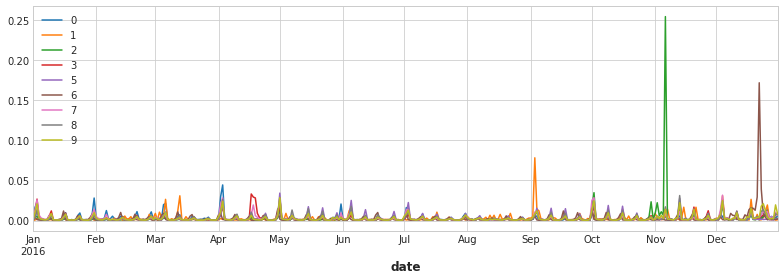

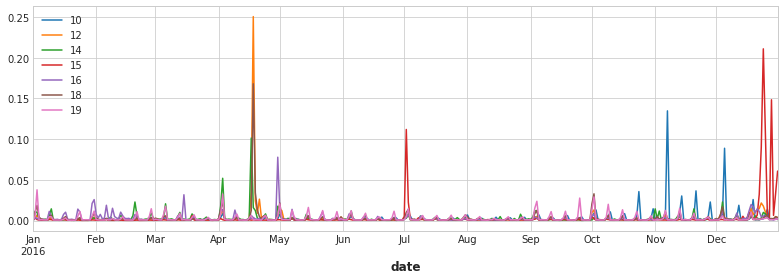

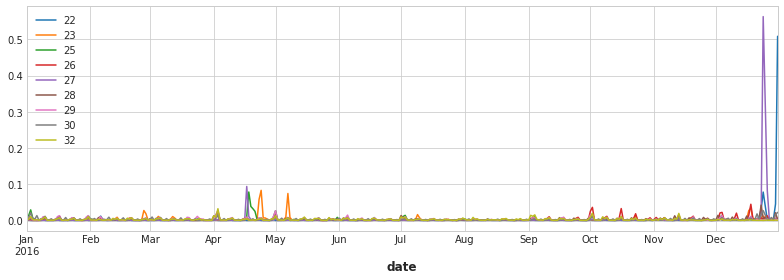

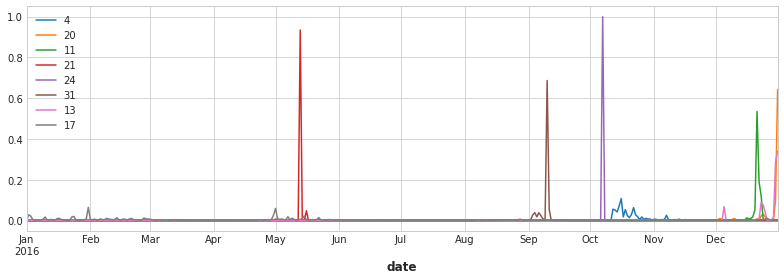

In [35]:
# From visual inspection, choose the proucts with higher sales along the year 
ax1 = df_softmax_norm.iloc[:,0:4].plot()
df_softmax_norm.iloc[:,5:10].plot(ax=ax1) 

ax2 = df_softmax_norm.iloc[:,10:11].plot()
df_softmax_norm.iloc[:,12:13].plot(ax=ax2)
df_softmax_norm.iloc[:,14:17].plot(ax=ax2)
df_softmax_norm.iloc[:,18:20].plot(ax=ax2)

ax3 = df_softmax_norm.iloc[:,22:24].plot()
df_softmax_norm.iloc[:,25:31].plot(ax=ax3)
df_softmax_norm.iloc[:,32:33].plot(ax=ax3)

#Not include the products below, these products show higher sales concentrated in short time 
ax4 = df_softmax_norm.iloc[:, [4,20,11,21,24,31,13,17]].plot() 

In [36]:
list_selected_products = list(set(np.arange(33))-set([4,20,11,21,24,31,13,17]))
df_softmax_norm.iloc[:, list_selected_products].describe()

,0,1,2,3,5,6,7,8,9,10,...,19,22,23,25,26,27,28,29,30,32
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,...,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,0.002740,0.002740,0.002740,0.002740,0.002740,0.002740,0.002740,0.002740,0.002740,0.002740,...,0.002740,0.002740,0.002740,0.002740,0.002740,0.002740,0.002740,0.002740,0.002740,0.002740
std,0.004416,0.005659,0.013675,0.004361,0.004512,0.009585,0.004344,0.004155,0.004085,0.009198,...,0.004714,0.027026,0.007265,0.005968,0.004872,0.030129,0.003623,0.003602,0.003350,0.003317
min,0.000048,0.000158,0.000076,0.000038,0.000012,0.000052,0.000022,0.000021,0.000024,0.000035,...,0.000148,0.000157,0.000101,0.000067,0.000047,0.000034,0.000023,0.000004,0.000012,0.000027
25%,0.000710,0.000745,0.000559,0.000712,0.000733,0.000616,0.000687,0.000731,0.000714,0.000585,...,0.000710,0.000336,0.000642,0.000637,0.000712,0.000238,0.000715,0.000771,0.000817,0.000730
50%,0.001073,0.001186,0.000857,0.001040,0.001119,0.000980,0.001130,0.001129,0.001222,0.000932,...,0.000908,0.000424,0.001150,0.001023,0.001037,0.000318,0.001375,0.001212,0.001390,0.001477
75%,0.002981,0.002576,0.002058,0.002768,0.002321,0.002175,0.002825,0.002713,0.002744,0.002015,...,0.002395,0.001065,0.002029,0.002504,0.002798,0.000662,0.003405,0.003139,0.003681,0.003530
max,0.044369,0.078193,0.254217,0.033088,0.034176,0.171725,0.031607,0.031120,0.028545,0.134745,...,0.037745,0.508456,0.083280,0.078709,0.044860,0.562865,0.042543,0.028207,0.027222,0.032554


[182 168 180 182 182 181 182 182 182 182 182 182 182 182 182 181 182 180
 182 181 182 182 182 182 182]
11.0
[91 85 91 91 91 91 91 91 91 91 91 87 91 91 91 91 91 91 91 90 91 91 91 91
 91]
2.0
10.0
20.0
[36 36 37 37 37 36 37 37 37 37 37 36 37 37 36 37 37 37 37 37 37 37 37 37
 37]
2.0
9.0


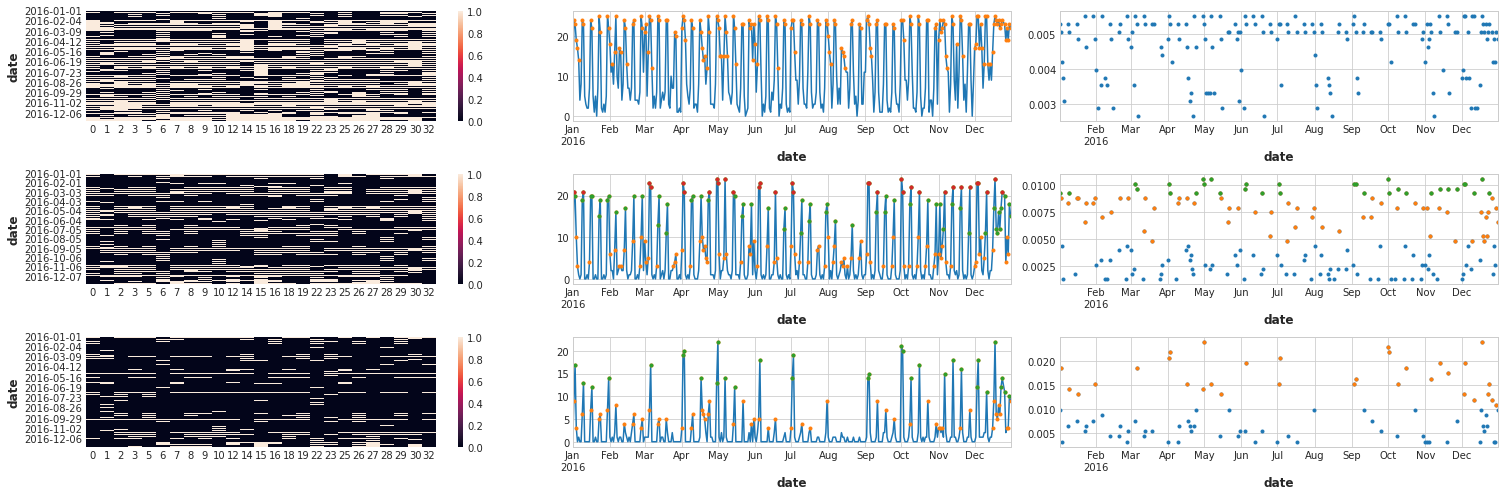

In [37]:
# we use quantile to select the most relevant dates
fig, ax = plt.subplots(3, 3, figsize=(21, 7))

i = 0
list_selected_quantiles2 = [[0.5], [0.5, 0.75, 0.9], [0.75, 0.9]]
df_features = pd.DataFrame(np.ones(df_softmax_norm.shape[0]), index=df_softmax_norm.index)
for quantile in [0.5, 0.75, 0.9]:
    df_important_dates_features = (df_softmax_norm.iloc[:,list_selected_products] - 
                                   df_softmax_norm.iloc[:,list_selected_products].quantile(quantile, axis=0))

    important_dates_binary = df_important_dates_features > 0
    print(important_dates_binary.sum().values.T)
    warnings.simplefilter("ignore")
    
    sns.heatmap(important_dates_binary, ax=ax[i][0])    
    important_dates_binary.sum(axis=1).plot(ax=ax[i][1])    
    for quantile_2 in list_selected_quantiles2[i]:
        thresold = important_dates_binary.sum(axis=1).quantile(quantile_2)  
        print(thresold)
        filter_tmp = important_dates_binary.sum(axis=1) > thresold
        important_dates_binary.sum(axis=1)[filter_tmp].plot(style='.', ax=ax[i][1])        
        
        binary_feature = 1.0*filter_tmp
        prob_feature = df_softmax_norm.mean(axis=1)*binary_feature
        
        relative_importance_feat = important_dates_binary.sum(axis=1)[filter_tmp]/important_dates_binary.sum(axis=1).sum()        
        relative_importance_feat.plot(style='.', ax=ax[i][2])
        
        df_features['binary_'+str(int(100*quantile))+'_'+str(int(100*quantile_2))] = binary_feature
        df_features['prob_'+str(int(100*quantile))+'_'+str(int(100*quantile_2))] = prob_feature        
        df_features['relative_'+str(int(100*quantile))+'_'+str(int(100*quantile_2))] = relative_importance_feat
    
    i += 1

In [38]:
df_features = df_features.replace(np.nan, 0.0)
df_features.drop([0], axis=1, inplace=True)
df_features.shape

(365, 18)

<AxesSubplot:xlabel='date'>

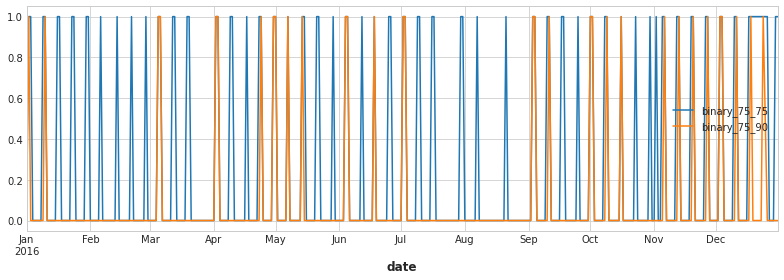

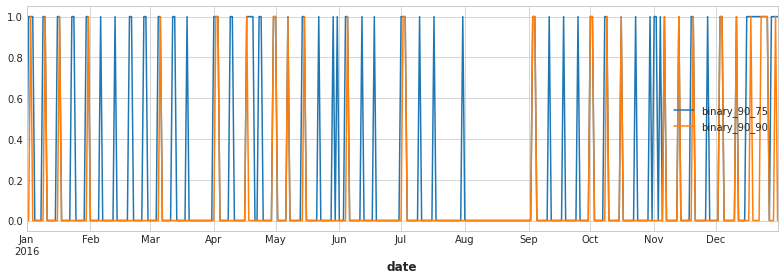

In [39]:
# df_features[['binary_50_50', 'binary_75_50']].plot()
df_features[['binary_75_75', 'binary_75_90']].plot()
df_features[['binary_90_75', 'binary_90_90']].plot()

<AxesSubplot:xlabel='date'>

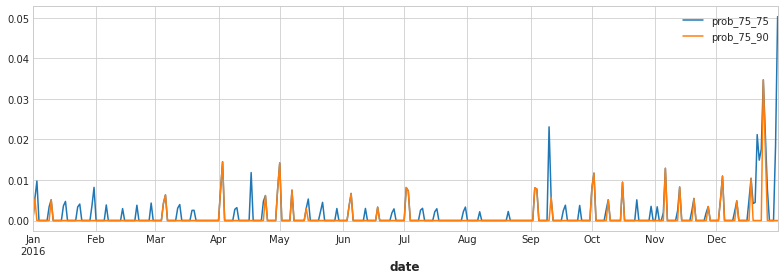

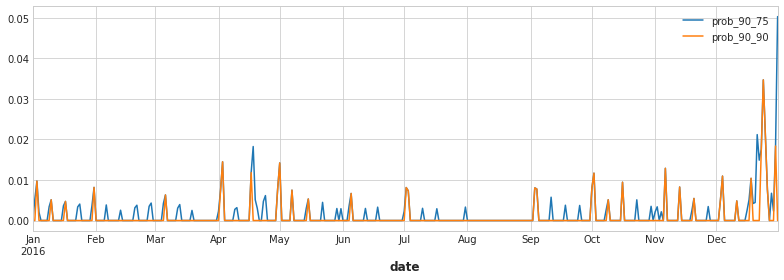

In [40]:
# df_features[['prob_50_50', 'prob_75_50']].plot()
df_features[['prob_75_75', 'prob_75_90']].plot()
df_features[['prob_90_75', 'prob_90_90']].plot()

<AxesSubplot:xlabel='date'>

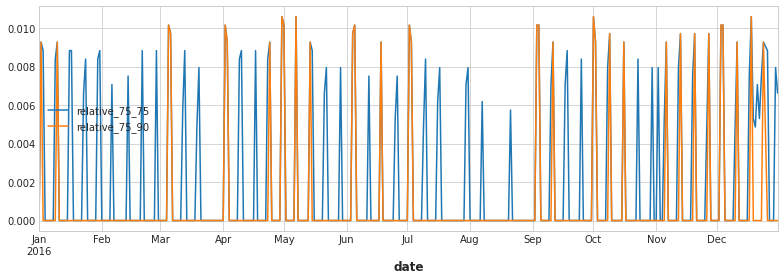

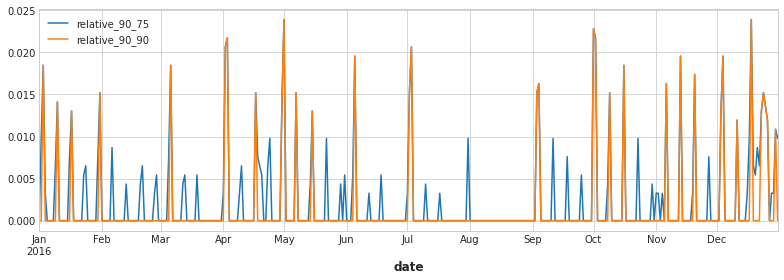

In [41]:
# df_features[['relative_50_50', 'relative_75_50']].plot()
df_features[['relative_75_75', 'relative_75_90']].plot()
df_features[['relative_90_75', 'relative_90_90']].plot()

## Models

In [42]:
# machine learning model
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression, Ridge

#hyper parameter search
from sklearn.model_selection import TimeSeriesSplit
import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.plots import plot_histogram, plot_objective_2D
from skopt.utils import use_named_args
import gc

In [43]:
def rmse_metric(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred, multioutput='raw_values'))

def split_data(x, y, size_test=15):
    x_train = x.iloc[:-size_test] 
    y_train = y.iloc[:-size_test] 

    x_test = x.iloc[-size_test:]
    y_test = y.iloc[-size_test:]
        
    return x_train, y_train, x_test, y_test

def ridge_model_config(param_tmp):
    model = Ridge(fit_intercept=True, 
                  alpha=param_tmp['alpha'],
                  solver=param_tmp['solver'],
                 max_iter=param_tmp['max_iter'])
    return model

def select_model(name_model, param, multioutput=True):
    if name_model == 'Ridge':
        return ridge_model_config(param)
    elif name_model == 'LinearRegression':
        return LinearRegression(fit_intercept=False)            
        
def cross_val_time_series(x, y, tscv, name_model, param_tmp, x_test=None, y_test=None, multioutput=False):
    list_metrics_train = []
    list_metrics_val = []
    #for train_index, val_index in tscv.time_sets_partition(): #tscv.split(np.arange(Y.shape[0])): 
    i = 0
    for train_index, val_index in tscv.split(np.arange(x.shape[0])):         
        print('train-val index shape:',train_index.shape, val_index.shape, ' fold:', i)        
        model_reg = select_model(name_model, param_tmp, multioutput=False)
        model_reg.fit(x.iloc[train_index, :], y.iloc[train_index, :])
        
        list_metrics_train.append(np.mean(rmse_metric(model_reg.predict(x.iloc[train_index, :]), y.iloc[train_index, :]))
                                 )
        list_metrics_val.append(np.mean(rmse_metric(model_reg.predict(x.iloc[val_index, :]), y.iloc[val_index, :]))
                                 )
        i += 1
    
    print('Performance by fold')
    df_perf = pd.DataFrame(np.vstack([list_metrics_train, list_metrics_val]))
    df_perf.columns = ['fold_'+str(i) for i in df_perf.columns]
    df_perf.index = ['train', 'val']
    print(df_perf)    
    if (x_test is not None) and (y_test is not None):        
        model_reg = select_model(name_model, param_tmp, multioutput=False)
        model_reg.fit(x, y)        
        print("Performance over all train data:", np.mean(rmse_metric(model_reg.predict(x), y)) )   
        metric_test = np.mean(rmse_metric(model_reg.predict(x_test), y_test))
        print("Performance over test data:",  metric_test)        
    print()
    return model_reg, metric_test


In [44]:
df_features.drop('2016-02-29', axis=0, inplace=True) #droping the '2016-02-29' that doesn't exist in 2017
X_feat_2016 = df_features.loc['2016-01-01':'2016-08-15', :] #use only the training dates
# X_feat_2016['new_year'] = X_base[['new_year']].values
X_feat_2016['constant'] = 1.0
X_feat_2016['trend'] = np.arange(X_feat_2016.shape[0])

Y =  mean_by_family_all_years.loc['2017']

print(X_base.shape)
print(X_feat_2016.shape, Y.shape)

(227, 16)
(227, 20) (227, 33)


In [96]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE

### **Linear Regression with x_base data**

In [90]:
# for i in np.random.randint(0, y_train.shape[1], 10):
#     print(i)
x_train.shape    

(212, 16)

In [100]:
x_data = X_base
y_data = Y

x_train, y_train, x_test, y_test = split_data(x_data, y_data, size_test=15)#26730)#495) #15)
print("all data:", x_data.shape, " x, y train:", x_train.shape, y_train.shape, 
      " x, y test:", x_test.shape, y_test.shape)
print()
    
tscv = TimeSeriesSplit(n_splits=3, max_train_size=x_train.shape[0], test_size=15)
# tscv = Sets_Partition(X_base.shape[0], size_val=15, num_sets=3) 
name_model = 'LinearRegression'

param_tmp = None
#X_base

features_set =[['const', 'trend'],
               ['s(2,7)', 's(3,7)', 's(4,7)', 's(5,7)', 's(6,7)', 's(7,7)'],
               ['sin(1,freq=M)', 'cos(1,freq=M)', 'sin(2,freq=M)', 'cos(2,freq=M)', 
                'sin(3,freq=M)', 'cos(3,freq=M)', 'sin(4,freq=M)', 'cos(4,freq=M)'],
               ['const', 'trend', 's(2,7)', 's(3,7)', 's(4,7)', 's(5,7)', 's(6,7)', 's(7,7)'],
               ['const', 'trend', 'sin(1,freq=M)', 'cos(1,freq=M)', 'sin(2,freq=M)', 'cos(2,freq=M)', 
                'sin(3,freq=M)', 'cos(3,freq=M)', 'sin(4,freq=M)', 'cos(4,freq=M)'],
               ['const', 'trend',  's(2,7)', 's(3,7)', 's(4,7)', 's(5,7)', 's(6,7)', 's(7,7)',
                'sin(1,freq=M)', 'cos(1,freq=M)', 'sin(2,freq=M)', 'cos(2,freq=M)', 
                'sin(3,freq=M)', 'cos(3,freq=M)', 'sin(4,freq=M)', 'cos(4,freq=M)'],
               list(x_train.columns),
              ]

best_metric = 1e6
best_features_base = None
for features in features_set:
    print('features:', features)
    model, metric_test = cross_val_time_series(x_train[features], y_train, tscv, name_model=name_model, param_tmp=param_tmp,
                                               x_test=x_test[features], y_test=y_test)
    if best_metric > metric_test:
        best_metric = metric_test
        best_features_base = features  

print("\n Best model")        
print(best_metric, best_features_base)      

print("\n ___VarianceThreshold selection___")
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
sel.fit_transform(x_train)
features = np.array(x_train.columns)[sel.get_support()]
print('features:', features)
model, metric_test = cross_val_time_series(x_train[features], y_train, tscv, name_model=name_model, param_tmp=param_tmp,
                                               x_test=x_test[features], y_test=y_test)

print("\n ___SelectKBest___")
list_tmp = []
for iteration in np.random.randint(0, y_train.shape[1], 10):
    sel = SelectKBest(mutual_info_regression, k=10)
    sel.fit_transform(x_train, y_train.iloc[:, iteration])
    features = np.array(x_train.columns)[sel.get_support()]
    list_tmp.append(features)
features = np.unique(list_tmp)
print('features:', features)
model, metric_test = cross_val_time_series(x_train[features], y_train, tscv, name_model=name_model, param_tmp=param_tmp,
                                           x_test=x_test[features], y_test=y_test)

print("\n ___RFE___")
estimator = LinearRegression()
sel = RFE(estimator, n_features_to_select=12, step=16)
sel.fit(x_train, y_train)
features = np.array(x_train.columns)[sel.get_support()]
# selector.ranking_
print('features:', features)
model, metric_test = cross_val_time_series(x_train[features], y_train, tscv, name_model=name_model, param_tmp=param_tmp,
                                           x_test=x_test[features], y_test=y_test)

all data: (227, 16)  x, y train: (212, 16) (212, 33)  x, y test: (15, 16) (15, 33)

features: ['const', 'trend']
train-val index shape: (167,) (15,)  fold: 0
train-val index shape: (182,) (15,)  fold: 1
train-val index shape: (197,) (15,)  fold: 2
Performance by fold
           fold_0      fold_1      fold_2
train  116.004488  115.489545  115.081664
val    110.065859  110.259409   90.622021
Performance over all train data: 113.52332084333221
Performance over test data: 79.46795636162211

features: ['s(2,7)', 's(3,7)', 's(4,7)', 's(5,7)', 's(6,7)', 's(7,7)']
train-val index shape: (167,) (15,)  fold: 0
train-val index shape: (182,) (15,)  fold: 1
train-val index shape: (197,) (15,)  fold: 2
Performance by fold
           fold_0      fold_1      fold_2
train  239.887066  238.042620  242.976107
val    216.405459  296.096557  224.004268
Performance over all train data: 241.71801074826377
Performance over test data: 209.02125863341766

features: ['sin(1,freq=M)', 'cos(1,freq=M)', 'sin(2,fre

In [ ]:
## with new_year feature
All features
train-val index:  (167,) (15,)
train-val index:  (182,) (15,)
train-val index:  (197,) (15,)
training over all train data
over_test_data: 63.44994808630994
           0          1          2
0  50.283325  49.377903  48.236864
1  39.957710  34.175560  38.924238

## without new_year feature
All features
train-val index:  (167,) (15,)
train-val index:  (182,) (15,)
train-val index:  (197,) (15,)
training over all train data
over_test_data: 68.78156978447022
           0          1          2
0  72.251879  70.110387  68.218680
1  41.420114  41.865520  37.565211

Best model
68.78156978447022 ['const', 'trend', 's(2,7)', 's(3,7)', 's(4,7)', 's(5,7)', 's(6,7)', 's(7,7)', 
                   'sin(1,freq=M)', 'cos(1,freq=M)', 'sin(2,freq=M)', 'cos(2,freq=M)', 'sin(3,freq=M)',
                   'cos(3,freq=M)', 'sin(4,freq=M)', 'cos(4,freq=M)']

### Linear Regression with feature from 2016 data

In [101]:
x_data = X_feat_2016
y_data = Y

x_train, y_train, x_test, y_test = split_data(x_data, y_data, size_test=15)#26730)#495) #15)
print("all data:", x_data.shape, " x, y train:", x_train.shape, y_train.shape, 
      " x, y test:", x_test.shape, y_test.shape)
print()
    
tscv = TimeSeriesSplit(n_splits=3, max_train_size=x_train.shape[0], test_size=15)
name_model = 'LinearRegression'

param_tmp = None

features_set =[['binary_50_50', 'binary_75_50', 'binary_75_75', 'binary_75_90', 'binary_90_75', 'binary_90_90'],
               ['prob_50_50', 'prob_75_50', 'prob_75_75', 'prob_75_90', 'prob_90_75', 'prob_90_90'],
               ['relative_50_50', 'relative_75_50', 'relative_75_75', 'relative_75_90', 'relative_90_75', 'relative_90_90'],
               ['constant', 'trend', 'binary_50_50', 'binary_75_50', 'binary_75_75', 'binary_75_90', 'binary_90_75', 'binary_90_90'],
               ['constant', 'trend', 'prob_50_50', 'prob_75_50', 'prob_75_75', 'prob_75_90', 'prob_90_75', 'prob_90_90'],
               ['constant', 'trend', 'relative_50_50', 'relative_75_50', 'relative_75_75', 'relative_75_90', 'relative_90_75', 'relative_90_90'],
               ['constant', 'trend', 'binary_50_50', 'binary_75_50', 'binary_75_75', 'binary_75_90', 'binary_90_75', 'binary_90_90',
                'relative_50_50', 'relative_75_50', 'relative_75_75', 'relative_75_90', 'relative_90_75', 'relative_90_90'],
               list(x_train.columns)
              ]

best_metric = 1e6
best_features_2016 = None
for features in features_set:
    print('features:', features)
    model, metric_test = cross_val_time_series(x_train[features], y_train, tscv, name_model=name_model, param_tmp=param_tmp,
                                               x_test=x_test[features], y_test=y_test)
    if best_metric > metric_test:
        best_metric = metric_test
        best_features_2016 = features  
        
print("\n Best model")                
print(best_metric, best_features_2016)        

print("\n ___VarianceThreshold selection___")
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
sel.fit_transform(x_train)
features = np.array(x_train.columns)[sel.get_support()]
print('features:', features)
model, metric_test = cross_val_time_series(x_train[features], y_train, tscv, name_model=name_model, param_tmp=param_tmp,
                                               x_test=x_test[features], y_test=y_test)

print("\n ___SelectKBest___")
list_tmp = []
for iteration in np.random.randint(0, y_train.shape[1], 10):
    sel = SelectKBest(mutual_info_regression, k=10)
    sel.fit_transform(x_train, y_train.iloc[:, iteration])
    features = np.array(x_train.columns)[sel.get_support()]
    list_tmp.append(features)
features = np.unique(list_tmp)
print('features:', features)
model, metric_test = cross_val_time_series(x_train[features], y_train, tscv, name_model=name_model, param_tmp=param_tmp,
                                           x_test=x_test[features], y_test=y_test)

print("\n ___RFE___")
estimator = LinearRegression()
sel = RFE(estimator, n_features_to_select=12, step=16)
sel.fit(x_train, y_train)
features = np.array(x_train.columns)[sel.get_support()]
# selector.ranking_
print('features:', features)
model, metric_test = cross_val_time_series(x_train[features], y_train, tscv, name_model=name_model, param_tmp=param_tmp,
                                           x_test=x_test[features], y_test=y_test)

all data: (227, 20)  x, y train: (212, 20) (212, 33)  x, y test: (15, 20) (15, 33)

features: ['binary_50_50', 'binary_75_50', 'binary_75_75', 'binary_75_90', 'binary_90_75', 'binary_90_90']
train-val index shape: (167,) (15,)  fold: 0
train-val index shape: (182,) (15,)  fold: 1
train-val index shape: (197,) (15,)  fold: 2
Performance by fold
           fold_0      fold_1      fold_2
train  342.198479  341.284176  338.778776
val    331.317377  307.706406  344.164763
Performance over all train data: 339.1686061525535
Performance over test data: 282.15666027109773

features: ['prob_50_50', 'prob_75_50', 'prob_75_75', 'prob_75_90', 'prob_90_75', 'prob_90_90']
train-val index shape: (167,) (15,)  fold: 0
train-val index shape: (182,) (15,)  fold: 1
train-val index shape: (197,) (15,)  fold: 2
Performance by fold
           fold_0      fold_1      fold_2
train  373.829294  376.202683  373.618467
val    405.487515  343.482684  360.486281
Performance over all train data: 372.7023652272845
Pe

In [ ]:
##  with and without new_year feature
cons , trend, relativity
train-val index:  (167,) (15,)
train-val index:  (182,) (15,)
train-val index:  (197,) (15,)
training over all train data
over_test_data: 66.92018462220327
            0           1           2
0  106.456593  105.546954  103.712944
1   96.363749   80.000725   75.683884 



### Linear Regression with base features + feature from 2016

In [102]:

## X_base + X_feature_2016
# x_data = X_base
x_data = pd.concat([pd.DataFrame(X_base.values), 
                    pd.DataFrame(X_feat_2016[['binary_50_50', 'prob_50_50', 'relative_50_50', 'binary_75_50',
                                             'prob_75_50', 'relative_75_50', 'binary_75_75', 'prob_75_75',
                                             'relative_75_75', 'binary_75_90', 'prob_75_90', 'relative_75_90',
                                             'binary_90_75', 'prob_90_75', 'relative_90_75', 'binary_90_90',
                                             'prob_90_90', 'relative_90_90']].values)], axis=1)

x_data.columns = list(X_base.columns) + ['binary_50_50', 'prob_50_50', 'relative_50_50', 'binary_75_50',
                                        'prob_75_50', 'relative_75_50', 'binary_75_75', 'prob_75_75',
                                        'relative_75_75', 'binary_75_90', 'prob_75_90', 'relative_75_90',
                                        'binary_90_75', 'prob_90_75', 'relative_90_75', 'binary_90_90',
                                        'prob_90_90', 'relative_90_90']
y_data = Y

x_train, y_train, x_test, y_test = split_data(x_data, y_data, size_test=15)#26730)#495) #15)
print("all data:", x_data.shape, " x, y train:", x_train.shape, y_train.shape, 
      " x, y test:", x_test.shape, y_test.shape)

tscv = TimeSeriesSplit(n_splits=3, max_train_size=x_train.shape[0], test_size=15)
name_model = 'LinearRegression'

features_set =[['const', 'trend', 's(2,7)', 's(3,7)', 's(4,7)', 's(5,7)', 's(6,7)', 's(7,7)', 
                'sin(1,freq=M)', 'cos(1,freq=M)', 'sin(2,freq=M)', 'cos(2,freq=M)', 
                'sin(3,freq=M)', 'cos(3,freq=M)', 'sin(4,freq=M)', 'cos(4,freq=M)',
                'relative_50_50', 'relative_75_50', 'relative_75_75', 'relative_75_90', 'relative_90_75', 'relative_90_90'],
               
                list(X_base.columns) + ['binary_50_50', 'binary_75_50', 'binary_75_75', 'binary_75_90', 'binary_90_75', 'binary_90_90', 
                                        'prob_50_50', 'prob_75_50', 'prob_75_75', 'prob_75_90', 'prob_90_75', 'prob_90_90',
                                        'relative_50_50', 'relative_75_50', 'relative_75_75', 'relative_75_90', 'relative_90_75', 'relative_90_90'],
               
                list(X_base.columns) + ['binary_50_50', 'binary_75_50', 'binary_75_75', 'binary_75_90', 'binary_90_75', 'binary_90_90',             
                                        'relative_50_50', 'relative_75_50', 'relative_75_75', 'relative_75_90', 'relative_90_75', 'relative_90_90'],
               
                list(X_base.columns) + ['relative_50_50', 'relative_75_50', 'relative_75_75', 'relative_75_90', 'relative_90_75', 'relative_90_90'],
               
                list(X_base.columns) + ['binary_50_50', 'binary_75_50', 'binary_75_75', 'binary_75_90', 'binary_90_75', 'binary_90_90']                              
              ]

best_metric = 1e6
best_features = None
for features in features_set:
    print('features:', features)
    model, metric_test = cross_val_time_series(x_train[features], y_train, tscv, name_model=name_model, param_tmp=param_tmp,
                                               x_test=x_test[features], y_test=y_test)
    if best_metric > metric_test:
        best_metric = metric_test
        best_features = features    
        
print("\n Best model")                
print(best_metric, best_features)    

print("\n ___VarianceThreshold selection___")
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
sel.fit_transform(x_train)
features = np.array(x_train.columns)[sel.get_support()]
print('features:', features)
model, metric_test = cross_val_time_series(x_train[features], y_train, tscv, name_model=name_model, param_tmp=param_tmp,
                                               x_test=x_test[features], y_test=y_test)

print("\n ___SelectKBest___")
list_tmp = []
for iteration in np.random.randint(0, y_train.shape[1], 10):
    sel = SelectKBest(mutual_info_regression, k=10)
    sel.fit_transform(x_train, y_train.iloc[:, iteration])
    features = np.array(x_train.columns)[sel.get_support()]
    list_tmp.append(features)
features = np.unique(list_tmp)
print('features:', features)
model, metric_test = cross_val_time_series(x_train[features], y_train, tscv, name_model=name_model, param_tmp=param_tmp,
                                           x_test=x_test[features], y_test=y_test)

print("\n ___RFE___")
estimator = LinearRegression()
sel = RFE(estimator, n_features_to_select=12, step=16)
sel.fit(x_train, y_train)
features = np.array(x_train.columns)[sel.get_support()]
# selector.ranking_
print('features:', features)
model, metric_test = cross_val_time_series(x_train[features], y_train, tscv, name_model=name_model, param_tmp=param_tmp,
                                           x_test=x_test[features], y_test=y_test)

all data: (227, 34)  x, y train: (212, 34) (212, 33)  x, y test: (15, 34) (15, 33)
features: ['const', 'trend', 's(2,7)', 's(3,7)', 's(4,7)', 's(5,7)', 's(6,7)', 's(7,7)', 'sin(1,freq=M)', 'cos(1,freq=M)', 'sin(2,freq=M)', 'cos(2,freq=M)', 'sin(3,freq=M)', 'cos(3,freq=M)', 'sin(4,freq=M)', 'cos(4,freq=M)', 'relative_50_50', 'relative_75_50', 'relative_75_75', 'relative_75_90', 'relative_90_75', 'relative_90_90']
train-val index shape: (167,) (15,)  fold: 0
train-val index shape: (182,) (15,)  fold: 1
train-val index shape: (197,) (15,)  fold: 2
Performance by fold
          fold_0     fold_1     fold_2
train  69.961884  67.970995  66.015773
val    42.321563  37.871415  34.677603
Performance over all train data: 64.31396519379847
Performance over test data: 69.35218782578887

features: ['const', 'trend', 's(2,7)', 's(3,7)', 's(4,7)', 's(5,7)', 's(6,7)', 's(7,7)', 'sin(1,freq=M)', 'cos(1,freq=M)', 'sin(2,freq=M)', 'cos(2,freq=M)', 'sin(3,freq=M)', 'cos(3,freq=M)', 'sin(4,freq=M)', 'cos(4

In [ ]:
## with new_year feature
train-val index:  (167,) (15,)
train-val index:  (182,) (15,)
train-val index:  (197,) (15,)
training over all train data
over_test_data: 58.88361223322576
           0          1          2
0  48.916961  48.063275  46.894327
1  41.474042  32.994527  38.942003 

## without new_year feature
train-val index:  (167,) (15,)
train-val index:  (182,) (15,)
train-val index:  (197,) (15,)
training over all train data
over_test_data: 65.33858772712408
           0          1          2
0  67.401309  65.272348  63.519174
1  37.547501  41.005695  40.053593 

In [ ]:
name_model = 'Ridge'
param_tmp =  {'alpha':30.0,
             'solver':'auto',
             'max_iter':None}
print(pd.DataFrame(cross_val_time_series(pd.concat([pd.DataFrame(X_base.values), 
                                                   pd.DataFrame(X_feat_2016[['binary_50_50', 'binary_75_50', 'binary_75_75', 
                                                                             'binary_75_90', 'binary_90_75', 'binary_90_90',             
                                                                             'relative_50_50', 'relative_75_50', 'relative_75_75', 
                                                                             'relative_75_90', 'relative_90_75', 'relative_90_90']].values)], axis=1, ignore_index=True),
                                        Y, tscv, name_model=name_model, param_tmp=param_tmp)))

Ridge
0.0
0  46.282350  46.894327  48.063275
1  58.883612  38.942003  32.994527
0.5
0  50.713260  51.697129  53.083881
1  63.462146  33.997276  37.827257
0.6   
0  51.553530  52.60112  54.032957
1  63.624936  33.69207  38.597811
0.8
0  53.105729  54.265433  55.773644
1  63.900333  33.298172  40.044991
1.5
0  57.224575  58.651749  60.323408
1  64.489134  33.045173  44.181105
2.5
0  60.895069  62.530251  64.301569
1  64.783092  33.674036  48.397809
3.5
0  63.317122  65.077513  66.890824
1  64.786938  34.573529  51.508718
4.5
0  65.116881  66.965877  68.798887
1  64.659009  35.534607  53.979280
5.0           
0  65.873052  67.758415  69.597132
1  64.569295  36.020165  55.049896
5.5
0  66.560342  68.478370  70.321139
1  64.469733  36.505084  56.035636
6.0
0  67.192069  69.139800  70.985456
1  64.363970  36.987687  56.949700
8.0
0  69.329880  71.375563  73.226444
1  63.923464  38.876040  60.067081
15.0
0  74.501236  76.755012  78.603652
1  62.730702  44.716344  67.372138
20.0
0  77.194256  79.530070  81.370946
1  62.296328  48.146752  70.907663
30.0
0  81.343287  83.760533  85.574306
1  62.098711  53.566277  75.988397